In [4]:
# 컴퓨터 디바이스(CPUI, GPU) 연동 확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6338224492469546284
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4755292160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10585122205621313361
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [5]:
# 사고영상 관절확인
import cv2 as cv
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#-- 파츠명 선언
BODY_PARTS = {
                "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                "Background": 15
            }

POSE_PAIRS = [["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]

#-- 모델 파일 불러오기
protoFile = "B:/openpose-master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt" #-- 자신의 환경에 맞게 경로 변경할 것
weightsFile = "B:/openpose-master/models/pose/mpi/pose_iter_160000.caffemodel" #-- 자신의 환경에 맞게 경로 변경할 것

#-- network 불러오기
net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)

#-- GPU 연동
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)

#-- 옵션 값 설정
threshold = 0.1
inputHeight = 368
inputWidth = 368
inputScale = 1.0/255

#-- 비디오 파일 경로
vedio_path = 'B:/data/accident.mp4' #-- 자신의 환경에 맞게 경로 변경할 것

cap = cv.VideoCapture(vedio_path) #-- 캠 이용 시 vedio_path 대신 0 입력

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
   #frame = cv.resize(frame, dsize=(320, 240), interpolation=cv.INTER_AREA)

    if not hasFrame:
        cv.waitKey()
        break
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inp = cv.dnn.blobFromImage(frame, inputScale, (inputWidth, inputHeight), (0, 0, 0), swapRB=False, crop=False)
    
    net.setInput(inp)
    out = net.forward()

    points = []
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = int((frameWidth * point[0]) / out.shape[3])
        y = int((frameHeight * point[1]) / out.shape[2])


        if conf > threshold:
            cv.circle(frame, (x, y), 3, (0, 255, 255), thickness=-1, lineType=cv.FILLED)
            cv.putText(frame, "{}".format(i), (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1, lineType=cv.LINE_AA)
            points.append((x, y))
        else:
            points.append(None)


    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 1)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    #-- 프레임 출력
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('OpenPose_vedio_test', frame)

In [6]:
# 프레스머신 관절확인
import cv2 as cv
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#-- 파츠명 선언
BODY_PARTS = {
                "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                "Background": 15
            }

POSE_PAIRS = [["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]

#-- 모델 파일 불러오기
protoFile = "B:/openpose-master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt" #-- 자신의 환경에 맞게 경로 변경할 것
weightsFile = "B:/openpose-master/models/pose/mpi/pose_iter_160000.caffemodel" #-- 자신의 환경에 맞게 경로 변경할 것

#-- network 불러오기
net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)

#-- GPU 연동
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)

#-- 옵션 값 설정
threshold = 0.1
inputHeight = 368
inputWidth = 368
inputScale = 1.0/255

#-- 비디오 파일 경로
vedio_path = 'B:/data/pressMachine.mp4' #-- 자신의 환경에 맞게 경로 변경할 것

cap = cv.VideoCapture(vedio_path) #-- 캠 이용 시 vedio_path 대신 0 입력

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
   #frame = cv.resize(frame, dsize=(320, 240), interpolation=cv.INTER_AREA)

    if not hasFrame:
        cv.waitKey()
        break
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inp = cv.dnn.blobFromImage(frame, inputScale, (inputWidth, inputHeight), (0, 0, 0), swapRB=False, crop=False)
    
    net.setInput(inp)
    out = net.forward()

    points = []
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = int((frameWidth * point[0]) / out.shape[3])
        y = int((frameHeight * point[1]) / out.shape[2])


        if conf > threshold:
            cv.circle(frame, (x, y), 3, (0, 255, 255), thickness=-1, lineType=cv.FILLED)
            cv.putText(frame, "{}".format(i), (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1, lineType=cv.LINE_AA)
            points.append((x, y))
        else:
            points.append(None)


    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 1)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    #-- 프레임 출력
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('OpenPose_vedio_test', frame)

In [5]:
# 촬영한 영상 확인
import cv2 as cv
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#-- 파츠명 선언
BODY_PARTS = {
                "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                "Background": 15
            }

POSE_PAIRS = [["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]

#-- 모델 파일 불러오기
protoFile = "B:/openpose-master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt" #-- 자신의 환경에 맞게 경로 변경할 것
weightsFile = "B:/openpose-master/models/pose/mpi/pose_iter_160000.caffemodel" #-- 자신의 환경에 맞게 경로 변경할 것

#-- network 불러오기
net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)

#-- GPU 연동
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)

#-- 옵션 값 설정
threshold = 0.1
inputHeight = 368
inputWidth = 368
inputScale = 1.0/255

#-- 비디오 파일 경로
vedio_path = 'B:/data/KakaoTalk_20230511_162705216.mp4' #-- 자신의 환경에 맞게 경로 변경할 것

cap = cv.VideoCapture(vedio_path) #-- 캠 이용 시 vedio_path 대신 0 입력

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
   #frame = cv.resize(frame, dsize=(320, 240), interpolation=cv.INTER_AREA)

    if not hasFrame:
        cv.waitKey()
        break
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inp = cv.dnn.blobFromImage(frame, inputScale, (inputWidth, inputHeight), (0, 0, 0), swapRB=False, crop=False)
    
    net.setInput(inp)
    out = net.forward()

    points = []
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = int((frameWidth * point[0]) / out.shape[3])
        y = int((frameHeight * point[1]) / out.shape[2])


        if conf > threshold:
            cv.circle(frame, (x, y), 3, (0, 255, 255), thickness=-1, lineType=cv.FILLED)
            cv.putText(frame, "{}".format(i), (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1, lineType=cv.LINE_AA)
            points.append((x, y))
        else:
            points.append(None)


    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 1)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    #-- 프레임 출력
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('OpenPose_vedio_test', frame)

In [ ]:
# 이미지 관절 확인
import cv2

#-- 파츠명 선언
BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                "Background": 15 }

POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
    
#-- 모델 파일 불러오기
protoFile = "B:/openpose-master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt" #-- 자신의 환경에 맞게 경로 변경할 것
weightsFile = "B:/openpose-master/models/pose/mpi/pose_iter_160000.caffemodel" #-- 자신의 환경에 맞게 경로 변경할 것
 
#-- network 불러오기
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

#-- 이미지 불러오기
image = cv2.imread("B:/data/images.jpg")

imageHeight, imageWidth, _ = image.shape #-- 불러온 이미지에서 height, width, color를 가져옴
 
inpBlob = cv2.dnn.blobFromImage(image, 1.0 / 255, (imageWidth, imageHeight), (0, 0, 0), swapRB=False, crop=False) #-- network에 적용하기 위한 전처리
 
net.setInput(inpBlob)

output = net.forward()

H = output.shape[2]
W = output.shape[3]

#-- 검출된 키포인트 적용 
points = []
for i in range(0,15):
    probMap = output[0, i, :, :]
 
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

    #-- 원본 이미지에 맞도록 포인트 위치 적용
    x = (imageWidth * point[0]) / W
    y = (imageHeight * point[1]) / H

    #-- 검출된 포인트가 BODY_PARRTS와 대응되면 포인트 추가(검출 결과가 0.1보다 크면) / 검출했으나 해당 파츠가 없는 경우 None    
    if prob > 0.1 :    
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED) #-- circle(이미지, 원의 중심, 반지름, 컬러)
        cv2.putText(image, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, lineType=cv2.LINE_AA)
        points.append((int(x), int(y)))
    else :
        points.append(None)

#-- 생성된 POSE_PAIRS에 맞게 라인 생성
for pair in POSE_PAIRS:
    partA = pair[0]             #-- 머리
    partA = BODY_PARTS[partA]   
    partB = pair[1]             #-- 목
    partB = BODY_PARTS[partB]   
    
    if points[partA] and points[partB]:
        cv2.line(image, points[partA], points[partB], (0, 255, 0), 2)


cv2.imshow("OpenPoseImgTest",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
# 이미지 관절 확인
import cv2

#-- 파츠명 선언
BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                "Background": 15 }

POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
    
#-- 모델 파일 불러오기
protoFile = "B:/openpose-master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt" #-- 자신의 환경에 맞게 경로 변경할 것
weightsFile = "B:/openpose-master/models/pose/mpi/pose_iter_160000.caffemodel" #-- 자신의 환경에 맞게 경로 변경할 것
 
#-- network 불러오기
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

#-- 이미지 불러오기
image = cv2.imread("B:/data/le.jpg")

imageHeight, imageWidth, _ = image.shape #-- 불러온 이미지에서 height, width, color를 가져옴
 
inpBlob = cv2.dnn.blobFromImage(image, 1.0 / 255, (imageWidth, imageHeight), (0, 0, 0), swapRB=False, crop=False) #-- network에 적용하기 위한 전처리
 
net.setInput(inpBlob)

output = net.forward()

H = output.shape[2]
W = output.shape[3]

#-- 검출된 키포인트 적용 
points = []
for i in range(0,15):
    probMap = output[0, i, :, :]
 
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

    #-- 원본 이미지에 맞도록 포인트 위치 적용
    x = (imageWidth * point[0]) / W
    y = (imageHeight * point[1]) / H

    #-- 검출된 포인트가 BODY_PARRTS와 대응되면 포인트 추가(검출 결과가 0.1보다 크면) / 검출했으나 해당 파츠가 없는 경우 None    
    if prob > 0.1 :    
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED) #-- circle(이미지, 원의 중심, 반지름, 컬러)
        cv2.putText(image, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, lineType=cv2.LINE_AA)
        points.append((int(x), int(y)))
    else :
        points.append(None)

#-- 생성된 POSE_PAIRS에 맞게 라인 생성
for pair in POSE_PAIRS:
    partA = pair[0]             #-- 머리
    partA = BODY_PARTS[partA]   
    partB = pair[1]             #-- 목
    partB = BODY_PARTS[partB]   
    
    if points[partA] and points[partB]:
        cv2.line(image, points[partA], points[partB], (0, 255, 0), 2)


cv2.imshow("OpenPoseImgTest",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Using GPU device
Time Taken = 0.5525217056274414


C:\Users\User\AppData\Local\Temp\ipykernel_1364\3166437292.py:192: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (7,5))


IndexError: index 44 is out of bounds for axis 1 with size 44

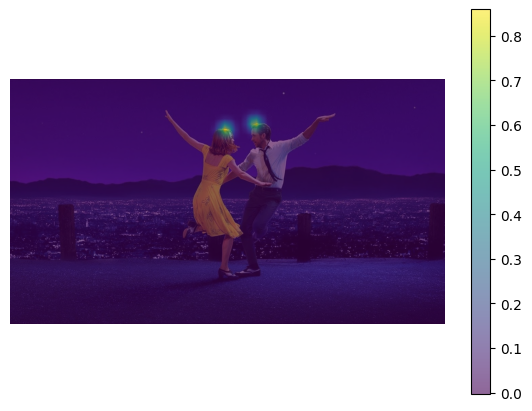

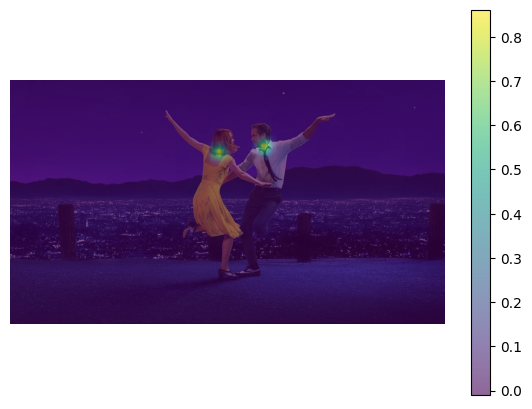

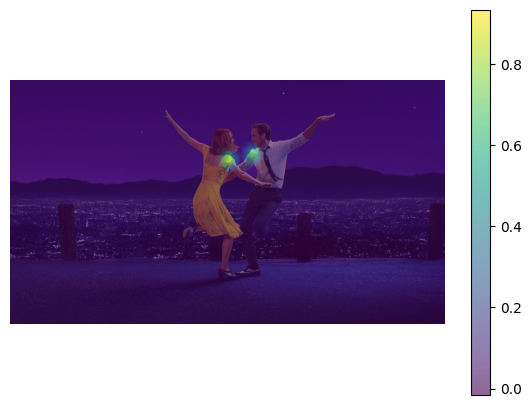

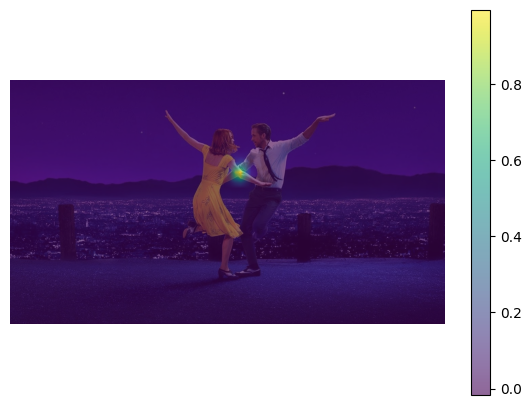

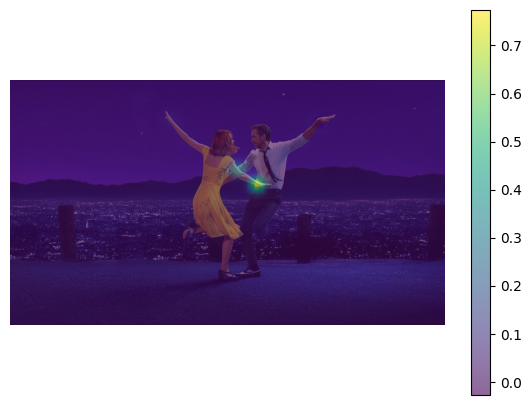

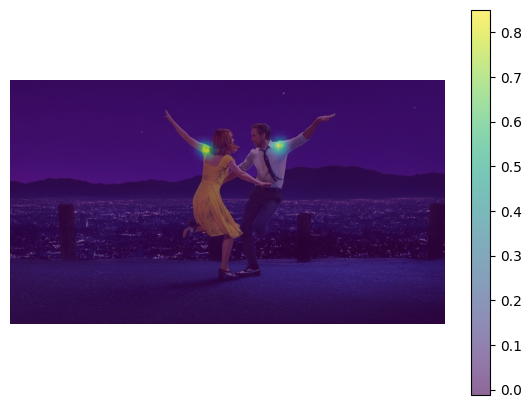

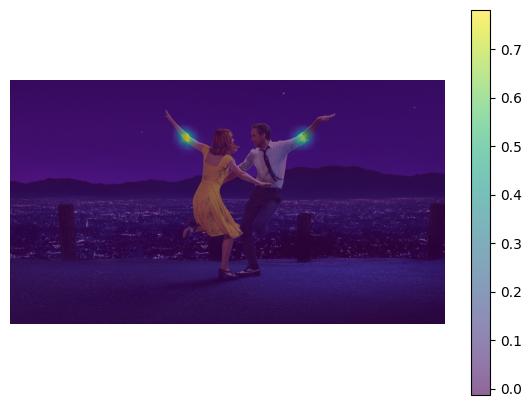

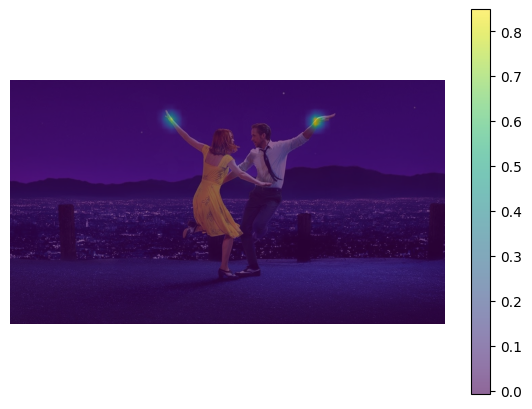

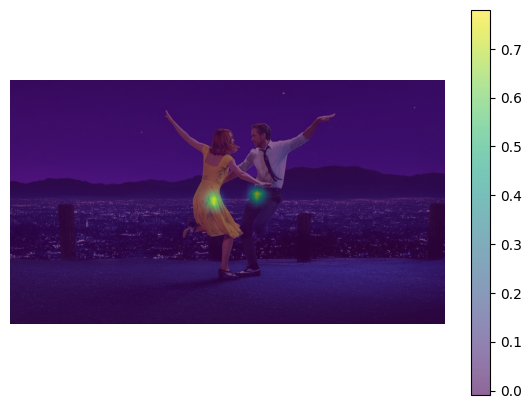

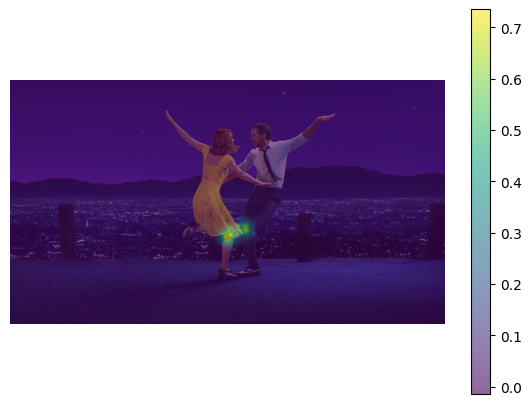

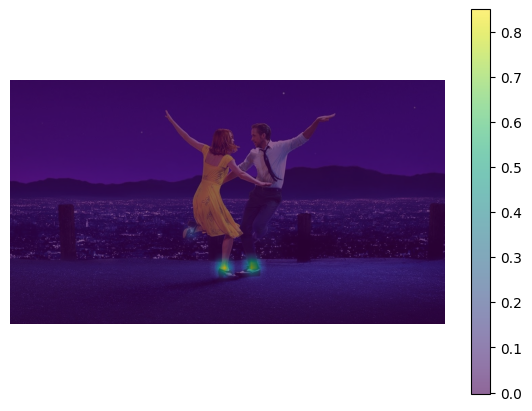

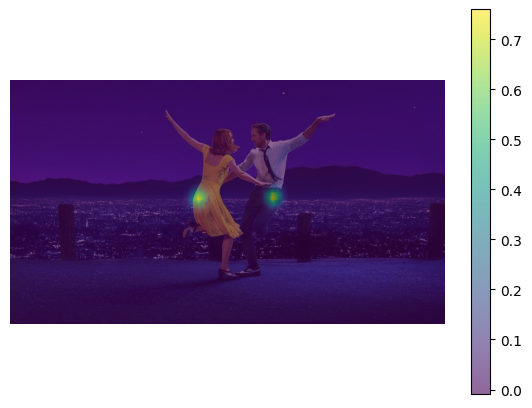

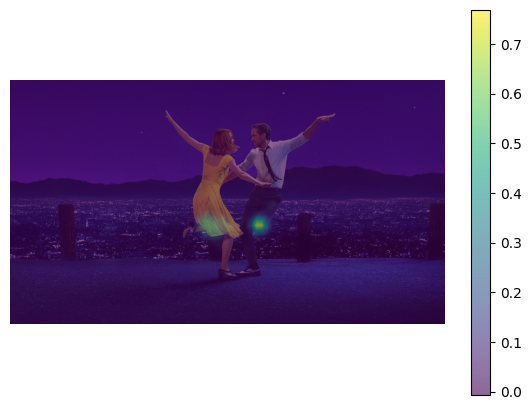

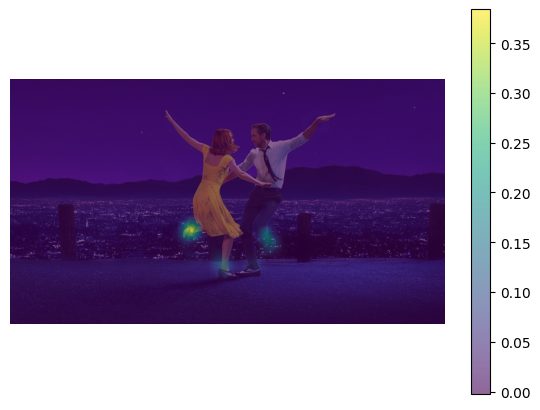

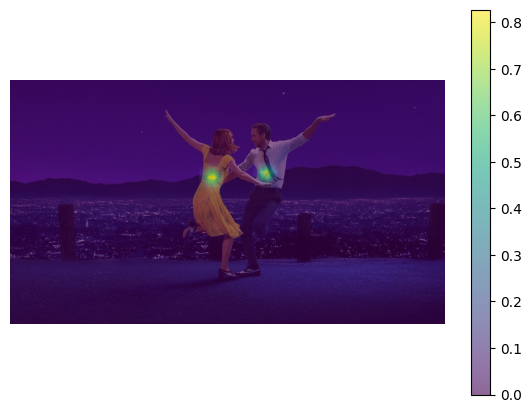

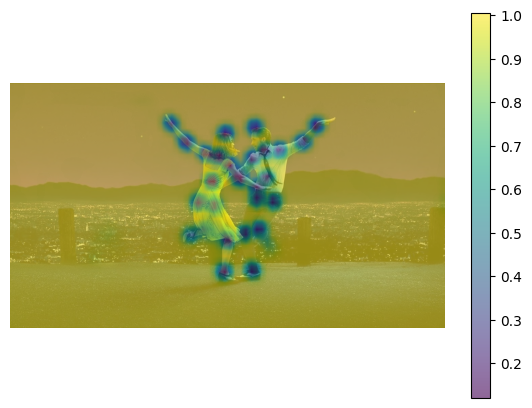

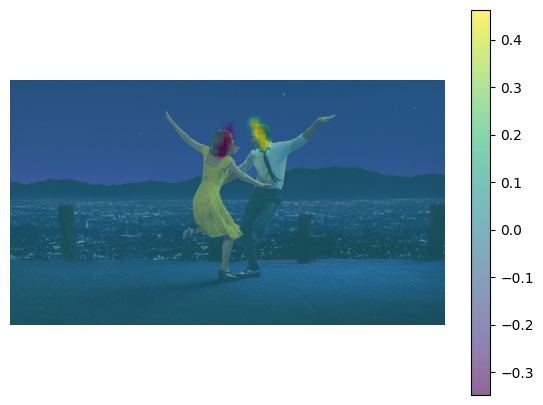

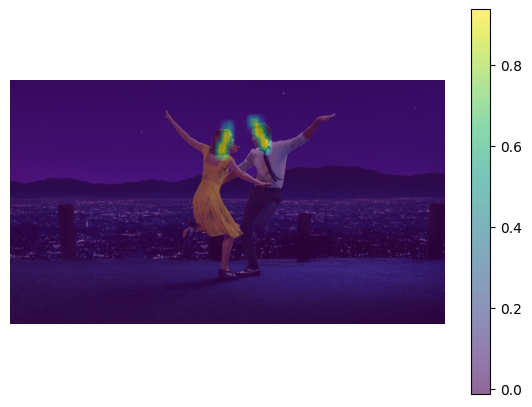

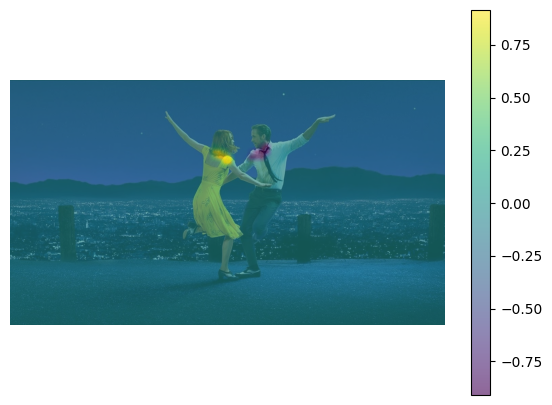

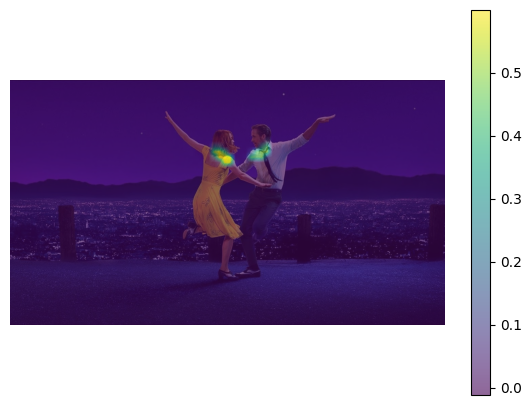

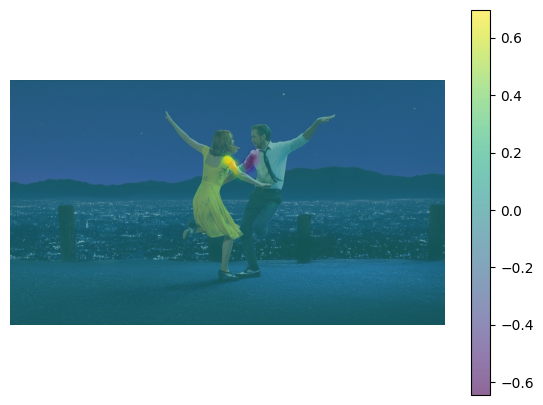

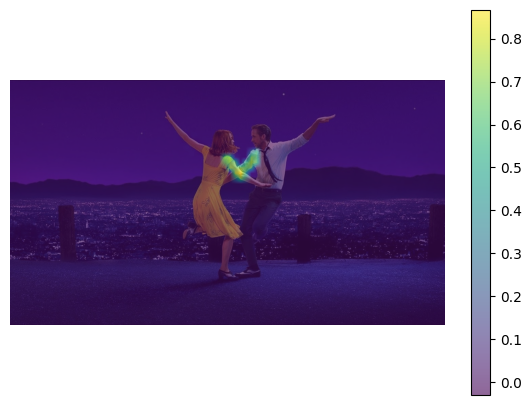

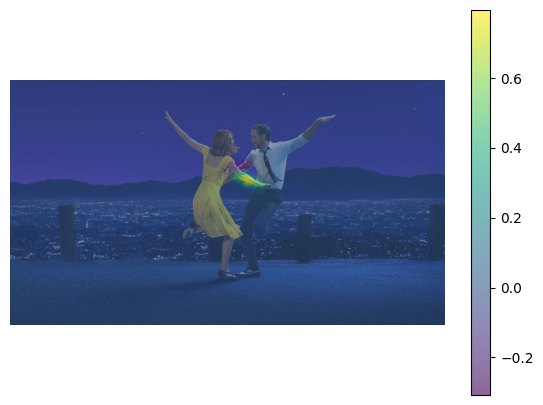

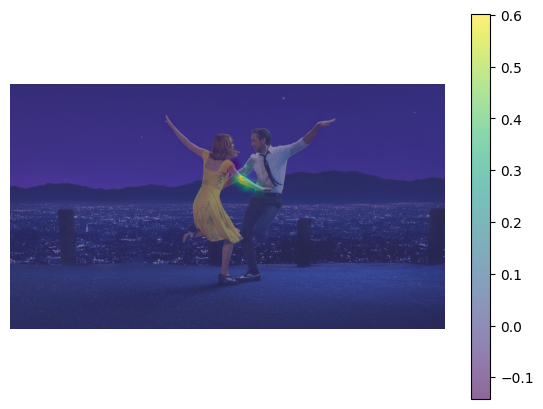

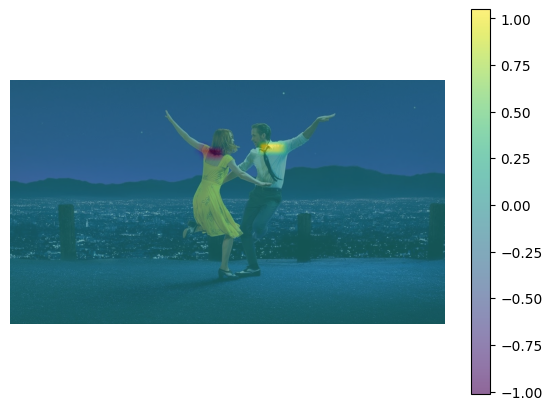

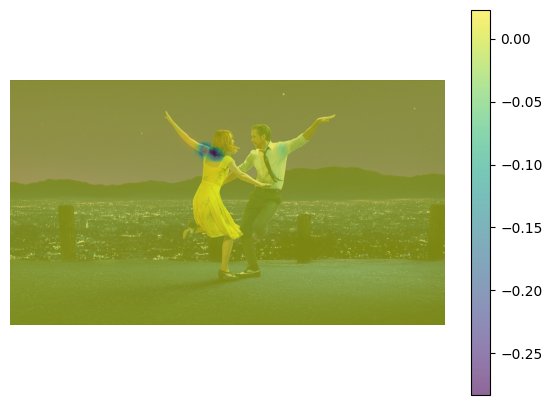

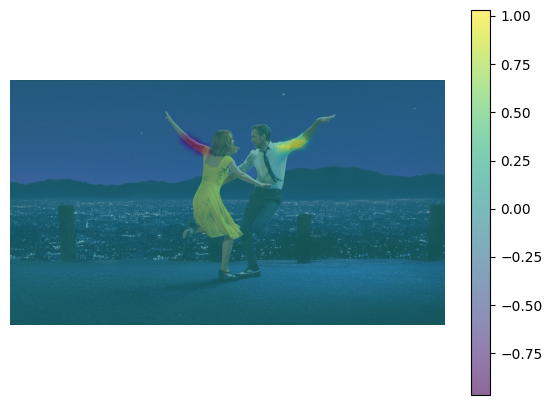

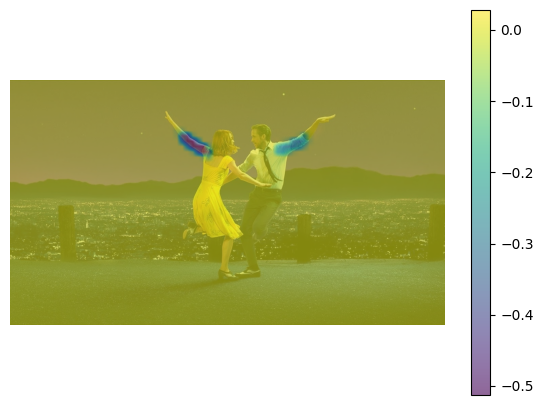

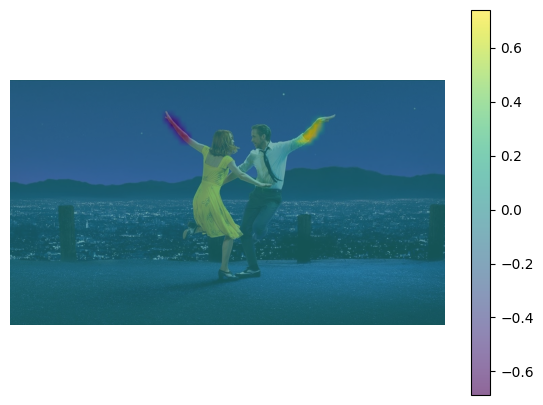

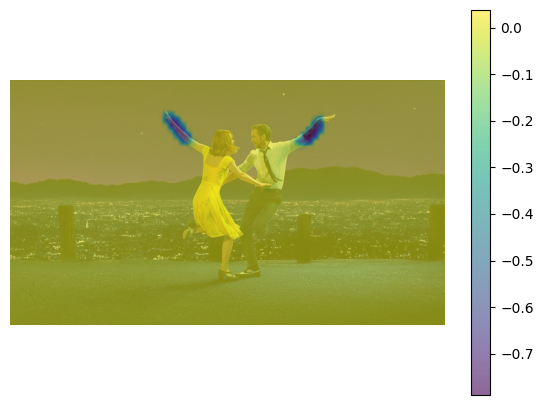

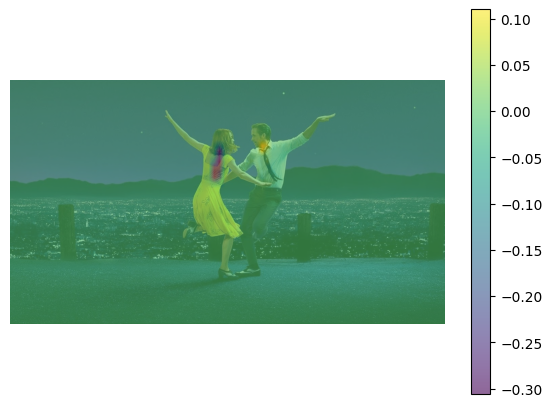

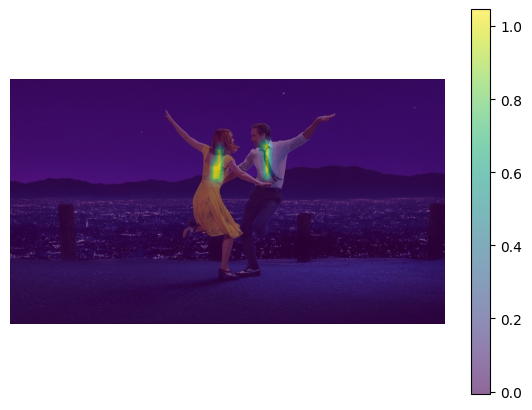

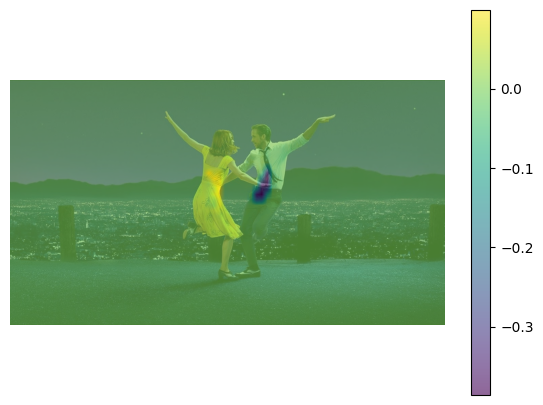

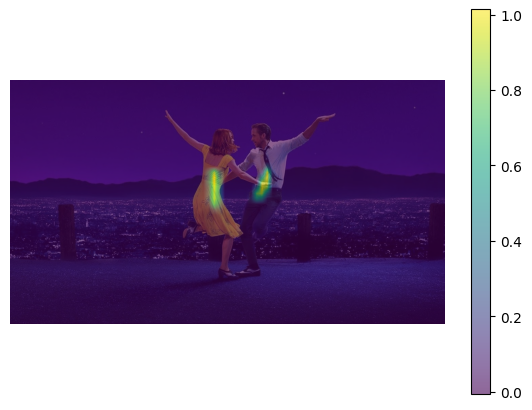

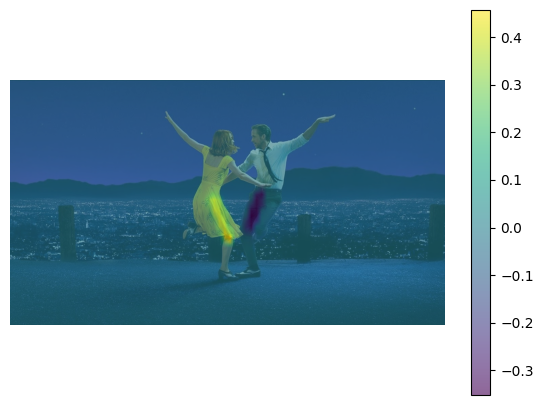

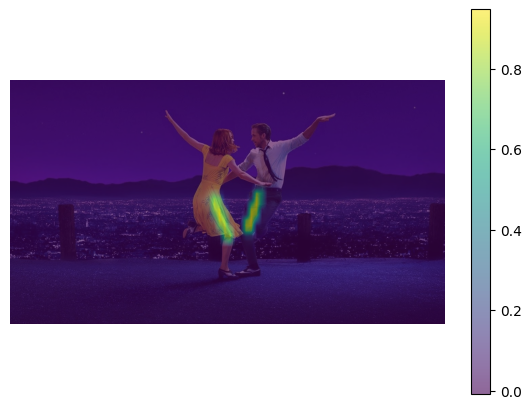

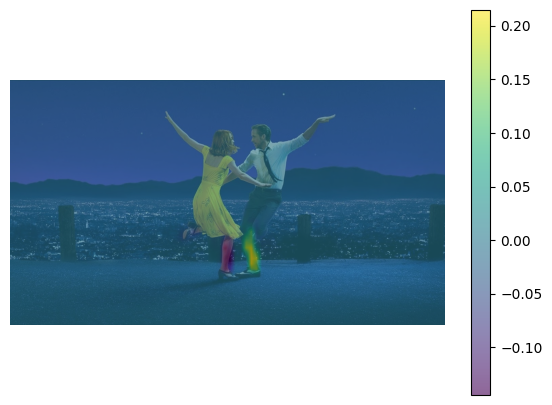

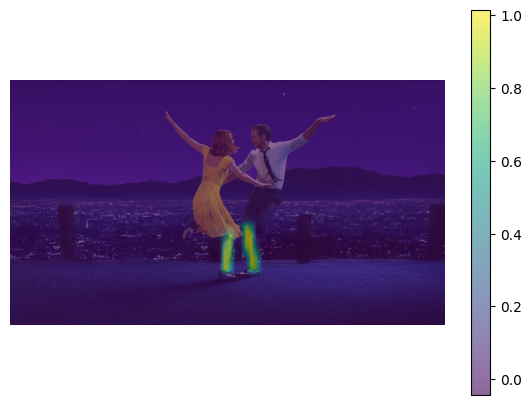

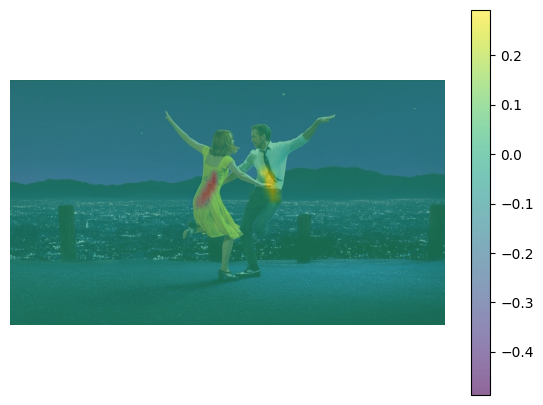

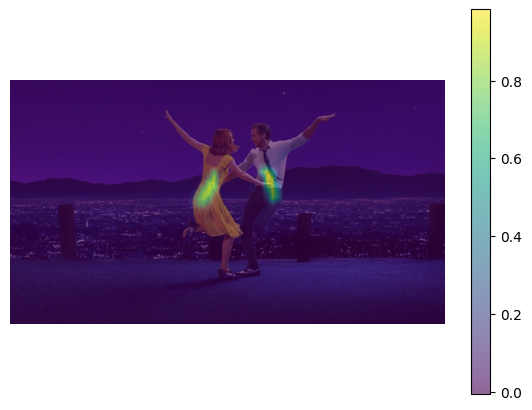

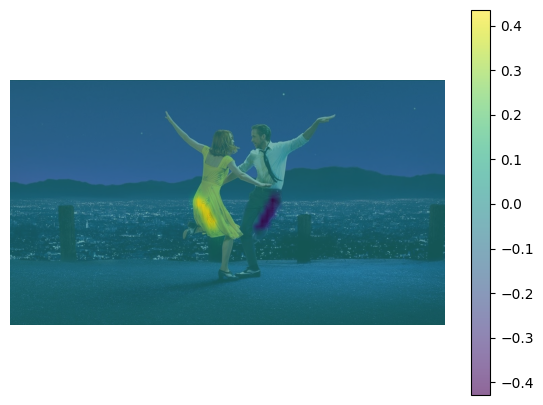

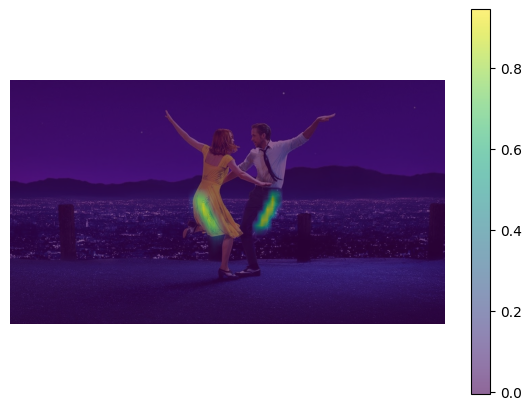

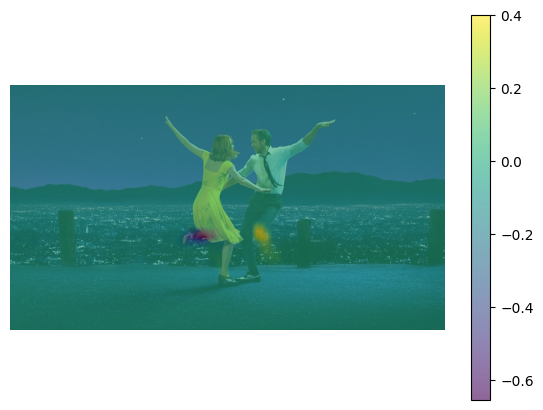

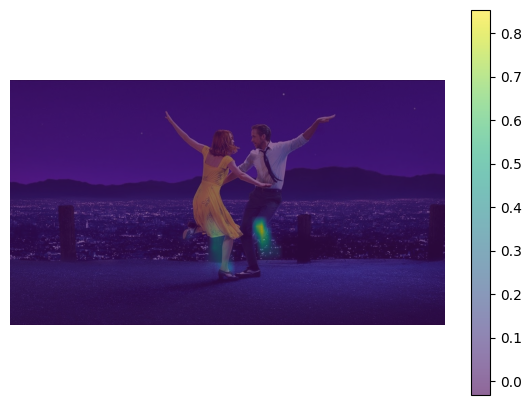

In [31]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

weightsFile = 'B:/openpose-master/models/pose/mpi/pose_iter_160000.caffemodel'
protoFile = 'B:/openpose-master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt'

nPoints = 25
keypointsMapping = ["Nose","Neck","RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow",
                    "LWrist", "MidHip", "RHip","RKnee", "RAnkle", "LHip", "LKnee",
                    "LAnkle", "REye", "LEye", "REar", "LEar", "LBigToe", "LSmallToe",
                     "LHeel",  "RBigToe", "RSmallToe", "RHeel"]

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],     
              [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14], 
              [11,24], [11,22], [22,23], [14,21],[14,19],[19,20],  
              [1,0], [0,15], [15,17], [0,16], [16,18],
              [2,17], [5,18]]
mapIdx = [[40,41],[48,49],[42,43],[44,45],[50,51],[52,53],
          [26,27],[32,33],[28,29],[30,31],[34,35],[36,37],
          [38,39],[76,77],[72,73],[74,75],[70,71],[66,67],
          [68,69],[56,57],[58,59],[62,63],[60,61],[64,65],
          [46,47],[54,55]]
colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [125,200,125], [125,200,0],
         [200,200,200],[200,100,200],[200,200,0],[0,200,0],[200,0,255],[0,250,125],
         [0,200,0],[0,120,200]]

device = 'gpu'

def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
   
    #for each blob find the maxima
    for cnt in contours:
       blobMask = np.zeros(mapMask.shape)
       blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
       maskedProbMap = mapSmooth * blobMask
       #maxVal = 있을 확률
       #maxLoc = x,y좌표
       _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
       keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))
    return keypoints

def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10 # 벡터를 나눌 수
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)
                    
            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint

def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 26))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 24:
                    row = -1 * np.ones(26)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints    

image1 = cv2.imread('B:/data/la.jpg ')
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]    

t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1,
                            1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

for i in range(78):
    n = i+1
    probMap = output[0,i,:,:]
    probMap = cv2.resize(probMap, (frameWidth, frameHeight))
    plt.figure(figsize = (7,5))
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.imshow(probMap, alpha=0.6)
    plt.colorbar()

    plt.axis("off")
    
plt.show()

detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)
print(detected_keypoints)

frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

valid_pairs, invalid_pairs = getValidPairs(output)

personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

for i in range(24):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[10,8])
plt.imshow(frameClone[:,:,[2,1,0]])